In [5]:
#paper:Energy, Quanta and vision, 1942

from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
filePath = 'poisson.csv';
# As file at filePath is deleted now, so we should check if file exists or not not before deleting them
if os.path.exists(filePath):
    os.remove(filePath)
else:
    print("Can not delete the file as it doesn't exists")    

Can not delete the file as it doesn't exists


In [7]:
import numpy as np 
import pandas as pd

In [15]:
# data preparation 

def prep_data(nave,nthres,nsamples,seed=0x00c0ffee):
    rs = np.random.RandomState(seed)
    data = poisson.rvs(nave, size=nsamples, random_state=rs)
    return data

In [18]:
# Data preperation & Modelling

nave     = 3    # mean number on cornea [n1, n2, n3, ...] number of shots
nthres   = 8    # threshold number of photons 
nsamples = 2000 # sample size  

data = prep_data(nave,nthres,nsamples,seed=0x00c0ffee)

In [22]:
# check for signal
data>nthres

array([False, False, False, ..., False, False, False])

/home/subasi/miniconda3/envs/nur/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


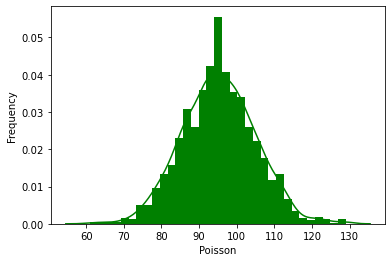

In [23]:
# Data preperation & Modelling

nbars = range(2, 96, 1) # mean number on cornea [n1, n2, n3, ...] number of shots
nth = 7;                  # threshold number of photons 
nsegment=2000              # size of the distribution 

class_array = np.zeros(shape=nsegment)
nbar_array = np.ones(shape=nsegment)
var_array = list()

#Data preperation

seed = 0x00c0ffee
rs = np.random.RandomState(seed)

for nbar in nbars: 
    data_binom = poisson.rvs(nbar, size=nsegment, random_state=rs)
    i=0
    for ni in data_binom:
        if ni>=nth:
            class_array[i] = 1 #yes
        else:
            class_array[i] = 0 #no
        i+=1
    var_array.append(poisson.var(nbar, loc = 0))  #variance of the distribution   
    
  #convert the signal into tabular DataFrame
    ni_df = pd.DataFrame(data_binom)
    class_df =  pd.DataFrame(class_array)
    nbar_df =pd.DataFrame(nbar*nbar_array)
    data_df = [ni_df, nbar_df]
    data_df = pd.concat(data_df, axis=1)
    data_df =pd.concat([data_df, class_df], axis = 1)
    
    data_df.to_csv('poisson.csv', mode='a', header=False)  #write data to file

#Visualize the last poisson distribution    
ax = sns.distplot(data_binom,
                  kde=True,
                  color='green',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Poisson', ylabel='Frequency')


data_pssn = pd.read_csv("poisson.csv")           #read distribution from data
data_pssn.columns = ["i", "ni", "nbar", "see"]   #convert dataframe i: segment number, ni: photon number, see: 0 or 1

X = data_pssn[["nbar", "ni"]]                    #features
y = data_pssn.see                                #label-target


variance = np.mean(var_array)

In [24]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

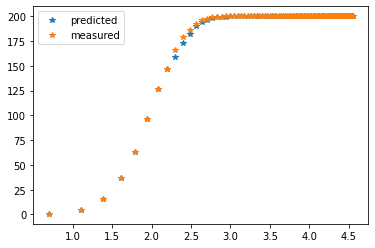

In [25]:
#cross-validated Logistic Regression model predictions
predicted = cross_val_predict(LogisticRegression(solver = "liblinear"), X, y, cv=10)

predicted = pd.DataFrame(predicted)   


#Data Frame Transformations made on predicted values

dfp = pd.concat([X, predicted], axis =1)
dfp.columns = ["nbar", "ni", "see"]

dfp = dfp[dfp["see"] ==1]   # select yes cases

dfp = dfp.groupby("nbar")["see"].value_counts()


dfp.to_csv('nbar_vs_percentage_predicted.csv')     #write data to file

#Data Analysis on predicted values
datap = pd.read_csv("nbar_vs_percentage_predicted.csv")    #read from data

datap = datap.rename(columns ={"see.1":"frequency"})

lognbar_p = np.log(datap["nbar"])

pp = datap["frequency"]

pp = 100*pp/(nsegment)

datap = [lognbar_p, pp]
datap = pd.concat(datap, axis =1)
datap.to_csv("predicted_lognbar_p_nth_"+str(nth)+".csv", index = False)

#Data Frame Transformations made on measured values

dfm= pd.concat([X, y], axis =1)
dfm.columns = ["nbar", "ni", "see"]

dfm = dfm[dfm["see"] ==1]   # select yes cases

dfm = dfm.groupby("nbar")["see"].value_counts()


dfm.to_csv('nbar_vs_percentage_measured.csv')  #write data to file

#Data Analysis on measured (real) values

datam = pd.read_csv("nbar_vs_percentage_measured.csv")    #read from data

datam = datam.rename(columns ={"see.1":"frequency"})

lognbar_m= np.log(datam["nbar"])

pm = datam["frequency"]

pm = 100*pm/(nsegment)

datam = [lognbar_m, pm]
datam = pd.concat(datam, axis =1)
datam.to_csv("measured_lognbar_p_nth_"+str(nth)+".csv", index = False)


plt.plot(lognbar_p, pp, "*")
plt.plot(lognbar_m, pm, "*")
plt.legend(["predicted", "measured"])
plt.show()

In [26]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

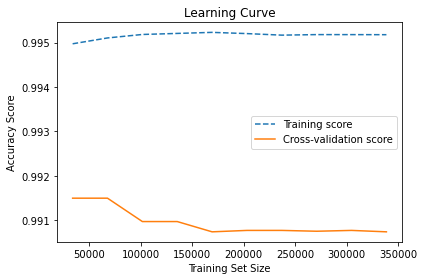

In [27]:
#Learning Rates 

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(solver="liblinear"), X, y, cv=10, shuffle = True, 
                                                        scoring = "accuracy", train_sizes=np.linspace(0.1, 1.0, 10))

#mean scores of train and test accuracies
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [28]:
#Learning Rates 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import csv
from csv import writer

f1_scores = cross_val_score(LogisticRegression(solver="liblinear"), X, y, cv=5, scoring = "f1") 

test_scores = cross_val_score(LogisticRegression(solver="liblinear"), X, y, cv=5, scoring = "accuracy") 


learning = [np.mean(f1_scores), np.mean(test_scores), variance ]

print(learning)

with open("learning_nth_"+str(nth)+".csv", mode = "a") as f:
    writer_object = writer(f)
    writer_object.writerow(learning)

[0.996111719521316, 0.9927686170212766, 48.5]
